# Experiment: Composite Annotation Search Using BERT for the PMR
- BERT is used to convert compositely annotated entities in biosimulation model repository (PMR) as vectors/embeddings.
- A query is converted into vector/embedding using BERT
- Calculate the similarity of the query's vector to entity's vectors
  - using cosine similarity

### Required packages

In [1]:
import pandas as pd
import json
from sentence_transformers import util
import torch
from tqdm import tqdm
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


### Load required data

In [2]:
# Dict of entity embeddings
entityEmbedding = torch.load('casbert_resources/pmr_entities.pt')

with open('casbert_resources/pmr_entities.json', 'r') as fp:
    entityKeys = json.load(fp)

# Dict of predicate embeddings
predicateEmbedding = torch.load('casbert_resources/pmr_predicates.pt')

# Dict of ontology class embedding
ontoEmbedding = torch.load('casbert_resources/pmr_classes.pt')

# load ontology dictionaries
import gzip, pickle
file = gzip.GzipFile('casbert_resources/ontoDf.gz', 'rb')
ontologies = pickle.load(file)
file.close()
    
# Query Set for test data
with open('casbert_resources/pmr_query_test.json', 'r') as fp:
    queryTest = json.load(fp)

In [3]:
# BERT model used
BERTModel = 'multi-qa-MiniLM-L6-cos-v1'
from sentence_transformers import SentenceTransformer, models
sbert = SentenceTransformer(BERTModel)

### Performance measure using Mean average Precision

In [4]:
def averagePrecision(prediction):
    if 1 not in prediction:
        return 0
    tot = 0
    for idx, p in enumerate(prediction):
        if p>0:
            tot += sum(prediction[0:idx+1])/(idx+1)
    return tot/sum(prediction)

def meanAP(predictions):
    tap = 0
    stat = {}
    for idx, prediction in enumerate(predictions):
        ap = averagePrecision(prediction)
        stat[idx] = ap
        tap += ap
    return {'score':tap/len(predictions), 'stat':stat}

def meanRR(predictions):
    trr = 0
    stat = {}
    for idx, prediction in enumerate(predictions):
        rr = 1/(prediction.index(1)+1) if 1 in prediction else 0
        stat[idx] = rr
        trr += rr
    return {'score':trr/len(predictions), 'stat':stat}

def getMAP(queries, searchFunction, indexType=None, pathType=None, topK=10, minSim=0.5):
    predictions = []
    for query, facts in tqdm(queries.items()):
        results = searchFunction(query=query, topK=topK, indexType=indexType, pathType=pathType, minSim=minSim)
        predictions += [[1 if varId in facts['vars'] else 0 for varId in results]]
    MAP = meanAP(predictions)
    return {'MAP':MAP,'MRR':meanRR(predictions)}
    

### Searching functions
Here we prepare several functions with different approah

In [5]:
# In some functions, we utilise scispacy to locate phrases or concepts related to a query. 
# For example a query 'Calcium reverse membrane potential.' 
# is identified having 2 concepts of 'calcium' and 'reverse membrane potential'
# For accurate identification we use 'en_core_sci_scibert' which required GPU for faster performance

import scispacy
import spacy
nlp = spacy.load("casbert_resources/en_core_sci_sm-0.4.0/")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'en_core_sci_sm' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [6]:
def entitySearch(query, topK=20, indexType='class', pathType=None, minSim=None):
    """
    In this approach:
    1. Get vector of query
    2. Get similar entities using cosine similarity
    3. Return topK result in descending
    """
    textEmbedding = sbert.encode(query, convert_to_tensor=True)
    # We use cosine-similarity and torch.topk to find the highest top_k scores
    cosScores = util.pytorch_cos_sim(textEmbedding, entityEmbedding[indexType])[0]
    topResults = torch.topk(cosScores, k=topK)
    entities = {}
    varIds = list(entityKeys.keys())
    for rank, (score, idx) in enumerate(zip(topResults[0], topResults[1])):
        entities[varIds[idx]] = [rank, score.item(), entityKeys[varIds[idx]]]
    return entities
    

In [7]:
# OntoEmbedding function

classId_List = ontoEmbedding['ClassId']
alpha = 0.22

# returning text
def getClassText(classId, features=['name']):
    """
    features: name, synonym, parent, def
    """
    corpus = {}
    if classId in classId_List:
        for feature in features:
            corpus[feature] = ontologies.loc[classId][feature]
    return corpus

# returning ontology classes
def getClasses(text, feature='name_synonym', topK = 20):
    """
    feature: name, name_synonym, name_synonym_def, name_synonym_def, name_synonym_def_parent
    """
    textEmbedding = sbert.encode(text, convert_to_tensor=True)
    # We use cosine-similarity and torch.topk to find the highest top_k scores
    if feature in ontoEmbedding:
        cosScores = util.pytorch_cos_sim(textEmbedding, ontoEmbedding[feature])[0]
        topResults = torch.topk(cosScores, k=topK)
        c = {}
        for rank, (score, idx) in enumerate(zip(topResults[0], topResults[1])):
            classId = classId_List[idx.item()]
            c[classId] = (rank, score.item(), ontologies.loc[classId]['name'])
        return c
    return None

def getPredicates(text, topK = 20):
    """
    text: string about predicate
    returning a dictionary of predicates ordered by similarities
    """
    textEmbedding = sbert.encode(text, convert_to_tensor=True)
    # We use cosine-similarity and torch.topk to find the highest top_k scores
    cosScores = util.pytorch_cos_sim(textEmbedding, torch.stack(list(predicateEmbedding.values())))[0]
    topResults = torch.topk(cosScores, k=topK)
    predicates = {}
    for rank, (score, idx) in enumerate(zip(topResults[0], topResults[1])):
        predicates[list(predicateEmbedding.keys())[idx]] = (rank, score.item())
    return predicates

In [8]:
def entitySearchClass(query, topK=20, minSim=0., indexType='class', pathType=None):
    """
    In this approach:
    1. Query is chunked into entities and classified into biomedical phrases and predicate
    2. Connect predicate to biomedical phrase
    3. If indexType is 'class', generate vector for biomedical phrase
    4. If indexType is 'class_predicate', generate vector for biomedical phrase and predicate pair
    5. Combine vectors becoming one vector using mean function
    6. Get similar entities encoding class_predicate using cosine similarity
    """
    
    doc = nlp(query)
    
    ontoClasses = []
    predicates = []
    validClassPredicates = {}
    offset2Class = {}
    for ent in doc.ents:
        predicateScores = getPredicates(ent.text, topK=1)
        pScore = list(predicateScores.values())[0][1]
        classScores = getClasses(ent.text, topK=1)
        cScore = list(classScores.values())[0][1]
        if cScore >= pScore:
            ontoClasses += [ent]
            for token in ent:
                offset2Class[token.i] = ent
        elif indexType=='class_predicate' and pScore >= minSim:
            predicates += [ent]
    
    if len(ontoClasses)==0: 
        ontoClasses = [doc]
    
    
    # check the entities describe by predicate (usually predicate's child)
    for ent in predicates:
        for token in ent:
            for child in token.children:
                if child.i in offset2Class:
                    idx = ontoClasses.index(offset2Class[child.i])
                    if idx not in validClassPredicates:
                        validClassPredicates[idx] = [ent]
                    else:
                        validClassPredicates[idx] += [ent]
                    break # only consider the closest class. remove break if considering all classes
                
    if indexType=='class':
        classEmbeddings = [sbert.encode(ent.text, convert_to_tensor=True) for ent in ontoClasses]
        textEmbedding = torch.mean(torch.stack(classEmbeddings, dim=0), dim=0)
    elif indexType=='class_predicate':
        classEmbeddings = []
        for i in range(len(ontoClasses)):
            classEmbedding = sbert.encode(ontoClasses[i].text, convert_to_tensor=True)
            if i in validClassPredicates:
                predicateEmbeddings = [sbert.encode(ent.text, convert_to_tensor=True) for ent in validClassPredicates[i]]
                pathEmbedding = alpha * torch.mean(torch.stack(predicateEmbeddings, dim=0), dim=0)
                classEmbedding = torch.mean(torch.stack([classEmbedding, pathEmbedding], dim=0), dim=0)
            classEmbeddings += [classEmbedding]
        textEmbedding = torch.mean(torch.stack(classEmbeddings, dim=0), dim=0)                                
        
    # We use cosine-similarity and torch.topk to find the highest top_k scores
    cosScores = util.pytorch_cos_sim(textEmbedding, entityEmbedding[indexType])[0]
    topResults = torch.topk(cosScores, k=topK)
    entities = {}
    varIds = list(entityKeys.keys())
    for rank, (score, idx) in enumerate(zip(topResults[0], topResults[1])):
        entities[varIds[idx]] = [rank, score.item(), entityKeys[varIds[idx]]]
    return entities

In [9]:
def entityEmbeddingCombine(macroEmbedding, microEmbedding, factor):
    textEmbedding = (1.9 * macroEmbedding + factor * microEmbedding)
    return textEmbedding

def entitySearchCombine(query, topK=20, minSim=0., indexType='class', pathType=None):
    """
    In this approach: combining entitySearch and entitySearchClass
    1. Query is chunked into entities and classified into biomedical phrases and predicate
    2. Connect predicate to biomedical phrase
    3. If indexType is 'class', generate vector for biomedical phrase
    4. If indexType is 'class_predicate', generate vector for biomedical phrase and predicate pair
    5. Combine vectors becoming one vector using mean function, named it as local vector
    6. Get vector of query named it as global vector
    7. Combine local vector and global vector
    8. Get similar entities using cosine similarity
    9. Return topK result in descending
    """

    ### Get local query embedding 
    
    doc = nlp(query)
    
    ontoClasses = []
    predicates = []
    validClassPredicates = {}
    offset2Class = {}
    cScores = []
    for ent in doc.ents:
        predicateScores = getPredicates(ent.text, topK=1)
        pScore = list(predicateScores.values())[0][1]
        classScores = getClasses(ent.text, topK=1)
        cScore = list(classScores.values())[0][1]
        if cScore >= pScore:
            cScores += [cScore]
            ontoClasses += [ent]
            for token in ent:
                offset2Class[token.i] = ent
        elif indexType =='class_predicate' and pScore >= minSim:
            predicates += [ent]
    
    if len(ontoClasses) == 0: 
        ontoClasses = [doc]
        cScores = [1]
            
    # check the entities describe by predicate (usually predicate's child)
    for ent in predicates:
        for token in ent:
            for child in token.children:
                if child.i in offset2Class:
                    idx = ontoClasses.index(offset2Class[child.i])
                    if idx not in validClassPredicates:
                        validClassPredicates[idx] = [ent]
                    else:
                        validClassPredicates[idx] += [ent]
                    break # only consider the closest class. remove break if considering all classes
                
    if indexType=='class':
        classEmbeddings = [sbert.encode(ent.text, convert_to_tensor=True) for ent in ontoClasses]
        textEmbedding = torch.mean(torch.stack(classEmbeddings, dim=0), dim=0)
    elif indexType=='class_predicate':
        classEmbeddings = []
        for i in range(len(ontoClasses)):
            classEmbedding = sbert.encode(ontoClasses[i].text, convert_to_tensor=True)
            if i in validClassPredicates:
                predicateEmbeddings = [sbert.encode(ent.text, convert_to_tensor=True) for ent in validClassPredicates[i]]
                pathEmbedding = alpha * torch.mean(torch.stack(predicateEmbeddings, dim=0), dim=0)
                classEmbedding = torch.mean(torch.stack([classEmbedding, pathEmbedding], dim=0), dim=0)
            classEmbeddings += [classEmbedding]
        textEmbedding = torch.mean(torch.stack(classEmbeddings, dim=0), dim=0)
        
    ### Get global query embedding
    textEmbeddingGlobal = sbert.encode(query, convert_to_tensor=True)
    ### Combine global and local embedding
    factor = sum(cScores)/len(cScores)
    textEmbedding = entityEmbeddingCombine(textEmbeddingGlobal, textEmbedding, factor)       
    
    # We use cosine-similarity and torch.topk to find the highest top_k scores
    cosScores = util.pytorch_cos_sim(textEmbedding, entityEmbedding[indexType])[0]
    topResults = torch.topk(cosScores, k=topK)
    entities = {}
    varIds = list(entityKeys.keys())
    for rank, (score, idx) in enumerate(zip(topResults[0], topResults[1])):
        entities[varIds[idx]] = [rank, score.item(), entityKeys[varIds[idx]]]
    return entities

In [10]:
# This part is experimenting with predicate use decided using classifier

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
modelClassifier = AutoModelForSequenceClassification.from_pretrained('casbert_resources/pmr_classifier_model/', num_labels=2)

def classifyQuery(model, sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs)
    return outputs.logits.argmax(dim=-1)[0]

In [11]:
def entitySearchCombine2(query, topK=20, minSim=0.5, indexType=None, pathType=None):
    """
    In this approach: combining entitySearch and entitySearchClass
    1. Query is chunked into entities and classified into biomedical phrases and predicate
    2. Connect predicate to biomedical phrase
    3. Here, the query is classify into 'class' or 'class_predicate'
        a. If indexType is 'class', generate vector for biomedical phrase
        b. If indexType is 'class_predicate', generate vector for biomedical phrase and predicate pair
    4. Combine vectors becoming one vector using mean function, named it as local vector
    5. Get vector of query named it as global vector
    6. Combine local vector and global vector
    7. Get similar entities using cosine similarity
    8. Return topK result in descending
    """
    
    ### Get local query embedding 
    
    doc = nlp(query)
    
    ontoClasses = []
    predicates = []
    validClassPredicates = {}
    offset2Class = {}
    cScores = []
    for ent in doc.ents:
       
        predicateScores = getPredicates(ent.text, topK=1)
        pScore = list(predicateScores.values())[0][1]
        classScores = getClasses(ent.text, topK=1)
        cScore = list(classScores.values())[0][1]
        if cScore >= pScore:
            cScores += [cScore]
            ontoClasses += [ent]
            for token in ent:
                offset2Class[token.i] = ent
        else:
            predicates += [ent]
    
    if len(ontoClasses) == 0: 
        ontoClasses = [doc]
        cScores = [1]
            
    # check the entities describe by predicate (usually predicate's child)
    for ent in predicates:
        for token in ent:
            for child in token.children:
                if child.i in offset2Class:
                    idx = ontoClasses.index(offset2Class[child.i])
                    if idx not in validClassPredicates:
                        validClassPredicates[idx] = [ent]
                    else:
                        validClassPredicates[idx] += [ent]
                    break # only consider the closest class. remove break if considering all classes
    
    classEmbeddings = []
    for i in range(len(ontoClasses)):
        classEmbedding = sbert.encode(ontoClasses[i].text, convert_to_tensor=True)
        if i in validClassPredicates:
            predicateEmbeddings = [sbert.encode(ent.text, convert_to_tensor=True) for ent in validClassPredicates[i]]
            pathEmbedding = alpha * torch.mean(torch.stack(predicateEmbeddings, dim=0), dim=0)
            classEmbedding = torch.mean(torch.stack([classEmbedding, pathEmbedding], dim=0), dim=0)
        classEmbeddings += [classEmbedding]
    textEmbedding = torch.mean(torch.stack(classEmbeddings, dim=0), dim=0)      
        
    ### Get global query embedding
    textEmbeddingGlobal = sbert.encode(query, convert_to_tensor=True)
    ### Combine global and local embedding
    factor = sum(cScores)/len(cScores)
    textEmbedding = entityEmbeddingCombine(textEmbeddingGlobal, textEmbedding, factor)       
    
    # We use cosine-similarity and torch.topk to find the highest top_k scores
    bestType = classifyQuery(modelClassifier, query)
    if bestType == 0:
        cosScores = util.pytorch_cos_sim(textEmbedding, entityEmbedding['class'])[0]
    else:
        cosScores = util.pytorch_cos_sim(textEmbedding, entityEmbedding['class_predicate'])[0]
    
    topResults = torch.topk(cosScores, k=topK)
    entities = {}
    varIds = list(entityKeys.keys())
    for rank, (score, idx) in enumerate(zip(topResults[0], topResults[1])):
        entities[varIds[idx]] = [rank, score.item(), entityKeys[varIds[idx]]]
    return entities

### Now check for TF-IDF BM-25, for based comparison

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
import re
def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return [m.group(0) for m in matches]

In [14]:
#### organised variable text as a plain text then store it into dataframe

# loop for each variable
varTexts = {'varId':[], 'name':[], 'name_synonym':[], 'name_synonym_def':[], 'name_synonym_predicate':[]}
for varId, value in entityKeys.items():
    if varId not in entityKeys: continue
    names = []
    synonyms = []
    definitions = []
    predicates = []
    for classId in value['classes']:
        textFeature = getClassText(classId, features=['name', 'synonym', 'def'])
        if len(textFeature)==0: 
            continue
        names += [textFeature['name']]
        synonyms += ['' if not isinstance(textFeature['synonym'], str) else textFeature['synonym']]
        definitions += ['' if not isinstance(textFeature['def'], str) else textFeature['def']]
        predicates += [' '.join([' '.join(camel_case_split(p)).lower() for ps in value['classes'][classId]['path'] for p in ps])]
                
    if len(names)==0: continue
    varTexts['varId'] += [varId]
    varTexts['name'] += [', '.join(set(names))]
    varTexts['name_synonym'] += [', '.join(set(names + synonyms))]
    varTexts['name_synonym_def'] += [', '.join(set(names + synonyms + definitions))]
    varTexts['name_synonym_predicate'] += [', '.join(set(names + synonyms + predicates))]

dfVarTexts = pd.DataFrame(varTexts)


In [15]:
""" Implementation of OKapi BM25 with sklearn's TfidfVectorizer
Distributed as CC-0 (https://creativecommons.org/publicdomain/zero/1.0/)
"""

from scipy import sparse


class BM25(object):
    def __init__(self, b=0.75, k1=1.6):
        self.vectorizer = TfidfVectorizer(norm=None, smooth_idf=False)
        self.b = b
        self.k1 = k1

    def fit(self, X):
        """ Fit IDF to documents X """
        self.vectorizer.fit(X)
        y = super(TfidfVectorizer, self.vectorizer).transform(X)
        self.avdl = y.sum(1).mean()
        
        self.X = super(TfidfVectorizer, self.vectorizer).transform(X)
        self.len_X = self.X.sum(1).A1

    def transform(self, q, X):
        """ Calculate BM25 between query q and documents X """
        b, k1, avdl, len_X, X = self.b, self.k1, self.avdl, self.len_X, self.X

        # apply CountVectorizer
        q, = super(TfidfVectorizer, self.vectorizer).transform([q])
        assert sparse.isspmatrix_csr(q)

        # convert to csc for better column slicing
        X = X.tocsc()[:, q.indices]
        denom = X + (k1 * (1 - b + b * len_X / avdl))[:, None]
        # idf(t) = log [ n / df(t) ] + 1 in sklearn, so it need to be coneverted
        # to idf(t) = log [ n / df(t) ] with minus 1
        idf = self.vectorizer._tfidf.idf_[None, q.indices] - 1.
        numer = X.multiply(np.broadcast_to(idf, X.shape)) * (k1 + 1)                                                          
        return (numer / denom).sum(1).A1



#------------ End of library impl. Followings are the example -----------------
bm25 = {}
for col in dfVarTexts.columns[1:]:
    bm25[col] = BM25()
    bm25[col].fit(dfVarTexts[col])
    

def entitySearchBM25(query, topK=20, indexType='name_synonym', pathType='single', minSim=0):
    """
    In this approach:
    Simply using bag of word method BM25
    """
    results = bm25[indexType].transform(query, dfVarTexts[indexType])

    sortedResults = {}
    for i in results.argsort()[-topK:][::-1]:
        sortedResults[dfVarTexts.iloc[i,0]] = (results[i], dfVarTexts.iloc[i,1])
        
    return sortedResults


## Now run to measure performance

In [16]:
results = {'noPredicate':{}, 'withPredicate':{}, 'combine':{}}
topK = 10

In [17]:
dataSetType = 'noPredicate'
querySet = queryTest[dataSetType]['2']
results[dataSetType]['macro'] = getMAP(querySet, entitySearch, topK=topK, indexType='class')
results[dataSetType]['macroWP'] = getMAP(querySet, entitySearch, topK=topK, indexType='class_predicate')
results[dataSetType]['micro'] = getMAP(querySet, entitySearchClass, topK=topK, indexType='class')
results[dataSetType]['microWP'] = getMAP(querySet, entitySearchClass, topK=topK, indexType='class_predicate')
results[dataSetType]['mixed'] = getMAP(querySet, entitySearchCombine, topK=topK, indexType='class')
results[dataSetType]['mixedWP'] = getMAP(querySet, entitySearchCombine, topK=topK, indexType='class_predicate')
results[dataSetType]['mixedCl'] = getMAP(querySet, entitySearchCombine2, topK=topK)
results[dataSetType]['BM25'] = getMAP(querySet, entitySearchBM25, topK=topK, indexType='name_synonym')

100%|██████████████████████████████████████| 338/338 [00:01<00:00, 284.72it/s]


In [18]:
dataSetType = 'withPredicate'
querySet = queryTest[dataSetType]['2']
results[dataSetType]['macro'] = getMAP(querySet, entitySearch, topK=topK, indexType='class')
results[dataSetType]['macroWP'] = getMAP(querySet, entitySearch, topK=topK, indexType='class_predicate')
results[dataSetType]['micro'] = getMAP(querySet, entitySearchClass, topK=topK, indexType='class')
results[dataSetType]['microWP'] = getMAP(querySet, entitySearchClass, topK=topK, indexType='class_predicate')
results[dataSetType]['mixed'] = getMAP(querySet, entitySearchCombine, topK=topK, indexType='class')
results[dataSetType]['mixedWP'] = getMAP(querySet, entitySearchCombine, topK=topK, indexType='class_predicate')
results[dataSetType]['mixedCl'] = getMAP(querySet, entitySearchCombine2, topK=topK)
results[dataSetType]['BM25'] = getMAP(querySet, entitySearchBM25, topK=topK, indexType='name_synonym_predicate')

100%|██████████████████████████████████████| 534/534 [00:01<00:00, 273.62it/s]


In [21]:
dataSetType = 'combine'
querySet = queryTest[dataSetType]
results[dataSetType]['macro'] = getMAP(querySet, entitySearch, topK=topK, indexType='class')
results[dataSetType]['macroWP'] = getMAP(querySet, entitySearch, topK=topK, indexType='class_predicate')
results[dataSetType]['micro'] = getMAP(querySet, entitySearchClass, topK=topK, indexType='class')
results[dataSetType]['microWP'] = getMAP(querySet, entitySearchClass, topK=topK, indexType='class_predicate')
results[dataSetType]['mixed'] = getMAP(querySet, entitySearchCombine, topK=topK, indexType='class')
results[dataSetType]['mixedWP'] = getMAP(querySet, entitySearchCombine, topK=topK, indexType='class_predicate')
results[dataSetType]['mixedCl'] = getMAP(querySet, entitySearchCombine2, topK=topK)
results[dataSetType]['BM25'] = getMAP(querySet, entitySearchBM25, topK=topK, indexType='name_synonym_predicate')

100%|███████████████████████████████████████| 509/509 [01:51<00:00,  4.57it/s]


### Analysis result

In [22]:
globalResults = {'approach':[], 'noPredicate_MAP':[], 'noPredicate_MRR':[], 'withPredicate_MAP':[], 'withPredicate_MRR':[], 'combine_MAP':[], 'combine_MRR':[]}

for approach in list(results.values())[0].keys():
    globalResults['approach'] += [approach]
    for dataType, v in results.items():
        globalResults[dataType+'_MAP'] += [v[approach]['MAP']['score']]
        globalResults[dataType+'_MRR'] += [v[approach]['MRR']['score']]

df_globalResults = pd.DataFrame(globalResults)
df_globalResults

,approach,noPredicate_MAP,noPredicate_MRR,withPredicate_MAP,withPredicate_MRR,combine_MAP,combine_MRR
0,macro,0.645216,0.643424,0.560255,0.564310,0.604036,0.603658
1,macroWP,0.626565,0.624992,0.582186,0.607913,0.602206,0.603909
2,micro,0.619483,0.617890,0.534427,0.549304,0.592228,0.595516
3,microWP,0.606255,0.608560,0.504055,0.515426,0.574869,0.579472
4,mixed,0.656636,0.656326,0.572109,0.583003,0.623287,0.624638
5,mixedWP,0.641843,0.641940,0.585494,0.612151,0.615885,0.621419
6,mixedCl,0.660346,0.659399,0.589960,0.615694,0.626420,0.631739
7,BM25,0.459375,0.443034,0.464496,0.487373,0.456505,0.457420


In [23]:
def updateQueryEntityScore(qTest):
    for query,v in tqdm(qTest.items()):
        pos = entityKeys[v['vars'][0]]['pos']
        queryEmb = sbert.encode(query, convert_to_tensor=True)
        entityEmb = entityEmbedding['class'][pos]
        cosScore = util.pytorch_cos_sim(entityEmb, queryEmb)
        v['score']  = cosScore.item()
        
updateQueryEntityScore(queryTest['noPredicate']['0'])
updateQueryEntityScore(queryTest['noPredicate']['1'])
updateQueryEntityScore(queryTest['noPredicate']['2'])
updateQueryEntityScore(queryTest['withPredicate']['0'])
updateQueryEntityScore(queryTest['withPredicate']['1'])
updateQueryEntityScore(queryTest['withPredicate']['2'])
updateQueryEntityScore(queryTest['combine'])

100%|███████████████████████████████████████| 509/509 [00:07<00:00, 72.32it/s]


In [24]:
detailResults = {'approach':[], 'dataType':[], 'query_Class_Sim':[], 'MAP':[], 'MRR':[]}
queryReference = {'noPredicate':[v['score'] for k,v in queryTest['noPredicate']['2'].items()], 
                  'withPredicate':[v['score'] for k,v in queryTest['withPredicate']['2'].items()], 
                  'combine':[v['score'] for k,v in queryTest['combine'].items()]} 

for approach in list(results.values())[0].keys():
    for dataType, v in results.items():
        for a,b,c in zip(queryReference[dataType], list(v[approach]['MAP']['stat'].values()), list(v[approach]['MRR']['stat'].values())):
            detailResults['approach'] += [approach]
            detailResults['dataType'] += [dataType]
            detailResults['query_Class_Sim'] += [a]
            detailResults['MAP'] += [b]
            detailResults['MRR'] += [c]

df_detailResults = pd.DataFrame(detailResults)
df_detailResults.head(1)

,approach,dataType,query_Class_Sim,MAP,MRR
0,macro,noPredicate,0.786003,1.0,1.0


In [25]:
dfPlot = df_detailResults[df_detailResults['dataType']=='combine']
dfPlot.query_Class_Sim = np.floor(dfPlot.query_Class_Sim*10)/10
dfPlot.loc[(dfPlot.query_Class_Sim == 1.0),'query_Class_Sim']=0.9

dfPlot.query_Class_Sim = dfPlot.query_Class_Sim.astype(str)+'-'+(dfPlot.query_Class_Sim+0.1).round(1).astype(str)
dfPlot.head(1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is

,approach,dataType,query_Class_Sim,MAP,MRR
872,macro,combine,0.7-0.8,1.0,1.0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


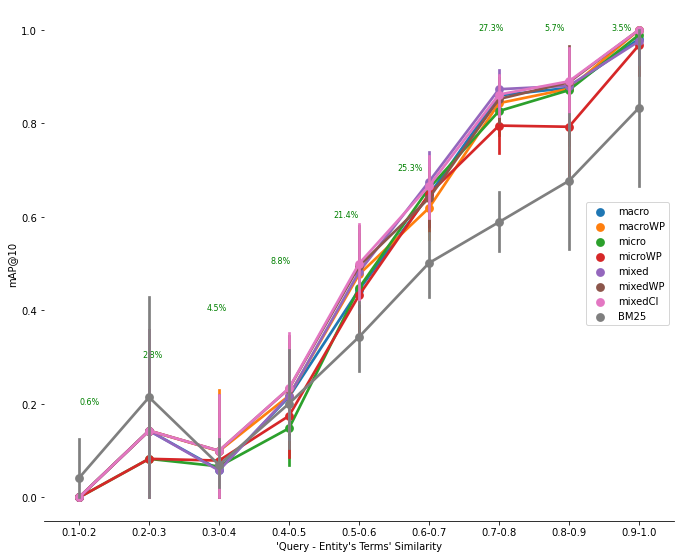

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# ax = sns.lineplot(x = "query_Class_Sim", y = "MAP", hue="approach", data = dfPlot)
order = dfPlot['query_Class_Sim'].unique().tolist()
order.sort()
ax = sns.factorplot(x = "query_Class_Sim", y = "MAP", hue="approach", data = dfPlot, order=order, legend=False)
ax.despine(left=True)
plt.legend(loc='right')
fig = plt.gcf()
fig.set_size_inches( 10, 8)
ax.set(xlabel="'Query - Entity's Terms' Similarity", ylabel="mAP@10")

counts = tuple((100.*dfPlot.groupby('query_Class_Sim').count()['approach']/dfPlot.shape[0]).round(1).astype(str)+'%')
for i, c in enumerate(counts):
    pos= (i*0.91, 0.2+i*0.1) if c not in counts[-3:] else (i*0.95, 1)
    plt.annotate(c, xy = pos, 
             fontsize = 8, xytext = pos, 
             color = 'g')
    
plt.show()

In [27]:
ax.savefig('casbert_results/fig_detail_result_pmr.png', dpi=400)